In [1]:
import timm
print(timm.__version__) 

0.4.12


In [5]:
from datasets import build_dataset
from run_class_finetuning import get_args,get_models



In [13]:
args, ds_init = get_args()
model = get_models(args)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [33]:
import torch

checkpoint = torch.load('../../persistent-data/leo/beit/downstream/output/checkpoint-best.pth',map_location='cpu')
checkpoint_model = checkpoint['model']

msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)


<All keys matched successfully>


In [34]:
dataset_train, nb_classes = build_dataset(is_train=True, args=args)
dataset_val, _ = build_dataset(is_train=False, args=args)

Transform = 
RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BICUBIC)
RandomHorizontalFlip(p=0.5)
ToTensor()
Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
---------------------------
Number of the class = 7
Transform = 
Resize(size=256, interpolation=bicubic, max_size=None, antialias=warn)
CenterCrop(size=(224, 224))
ToTensor()
Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
---------------------------
Number of the class = 7


In [35]:
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,  # Dataset to load
    sampler=torch.utils.data.RandomSampler(dataset_train),  # Randomly sample data
    batch_size=args.batch_size,  # Batch size for training
    num_workers=args.num_workers,  # Number of worker processes to use
    pin_memory=args.pin_mem,  # Whether to pin memory for faster data transfer to GPU
    drop_last=True,  # Drop the last incomplete batch if the dataset size is not divisible by batch_size
)

data_loader_val = torch.utils.data.DataLoader(
        dataset_val,  # Dataset to load
        sampler=torch.utils.data.SequentialSampler(dataset_val),  # Sequentially sample data
        batch_size=int(1.5 * args.batch_size),  # Larger batch size for validation
        num_workers=args.num_workers,  # Number of worker processes to use
        pin_memory=args.pin_mem,  # Whether to pin memory for faster data transfer to GPU
        drop_last=False  # Keep the last incomplete batch
    )



In [36]:
from itertools import chain
from tqdm import tqdm
import numpy as np

def mae_classification_pass(data_loader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print('using ',device)
    # initialize for loop
    preds = list()
    targets = list()
    for batch in tqdm(data_loader):
        images = batch[0].to(device)
        target = batch[-1].to(device)
     
        output = model(images)
        pred = torch.argmax(output, dim=1)

        #images_for_plot = torch.einsum('nchw -> nhwc', images)
        #plt.plot(images_for_plot[0,0,:,3], label="x")
        #plt.plot(np.repeat(target, 200), label="target")
        #plt.plot(np.repeat(pred, 200), label="pred")
        #plt.show()

        preds.append(pred.cpu().numpy())
        targets.append(target.cpu().numpy())

    #print("image shape:", images.shape, "target shape:", target.shape, "output shape:", output.shape)
    #print("target:", target, "pred:", pred)

    #acc1, acc3 = accuracy(output, target, topk=(1, 3)) 
    #print("acc1, acc3:", acc1, acc3)
    preds_list = list(chain(*preds))
    targets_list = list(chain(*targets))
    accordance = np.array(preds_list) == np.array(targets_list)
    accuracy = np.sum(accordance)/len(preds_list)

    return preds_list, targets_list, accuracy

In [37]:
pred_all, target_all, accuracy_all = mae_classification_pass(data_loader_train,model)

using  cuda


100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


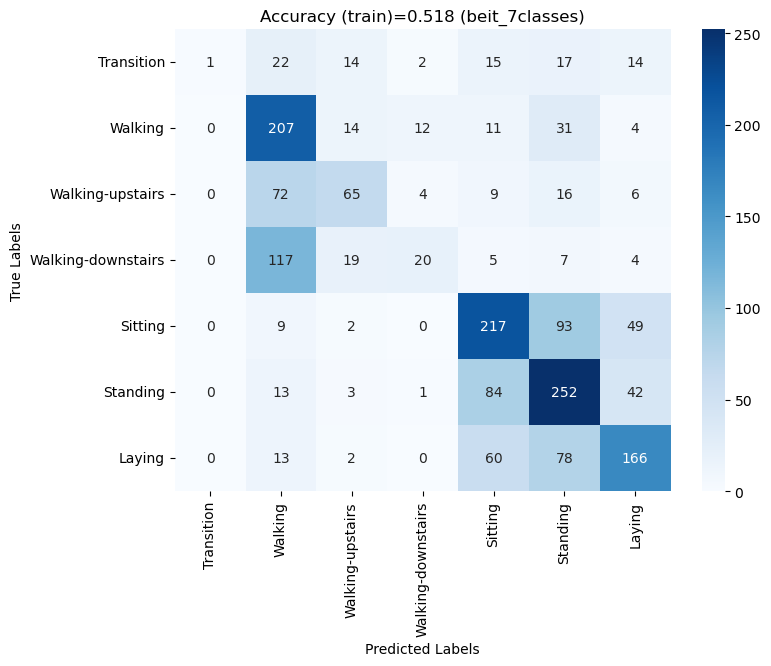

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

trial_classification = 'beit_7classes'

cm_all = confusion_matrix(target_all, pred_all)

#labels = ['Transition', 'Walking', 'Sitting', 'Standing', 'Laying']
labels = ['Transition', 'Walking', 'Walking-upstairs', 'Walking-downstairs', 'Sitting', 'Standing', 'Laying']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Blues', fmt='d', xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Accuracy (train)={round(accuracy_all,3)} ({trial_classification})')
plt.show()

